# Using `cartopy` for Plots with Rotated Lon/Lat Grids



## References

* [`cartopy` Documentation](https://scitools.org.uk/cartopy/docs/latest/index.html)
* [`cartopy` Code on GitHub](https://github.com/SciTools/cartopy)

## The Problem

Ocean model grids are often rotated at arbitrary angles from North/South
so as to maximize the ratio of water to land in the model domain.
Doing so makes the model computation more efficient because less time is
spent visiting all-land grid cells.
The SalishSeaCast NEMO grid is rotated approximately 29°
so that the y-axis of the model grid is more or less aligned with the along-strait axis
of the Strait of Georgia.

A consequence of such model grid rotations is that plotting model fields on grid coordinates
(that are familiar to people who run the model)
make efficient use of the plot frame,
but plotting fields on lon/lat coordinates
(that provides geographical context for people less familiar with the model)
can waste a lot of space in the plot frame:

In [1]:
import cartopy.crs
import cmocean.cm
import matplotlib.pyplot as plt
import numpy
import xarray

In [2]:
%matplotlib inline

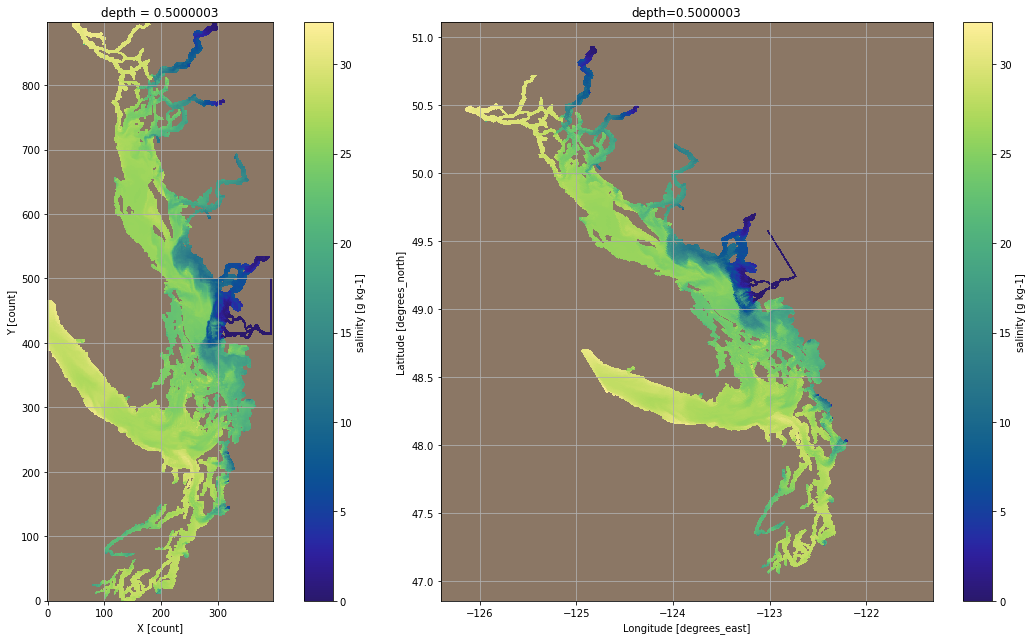

In [46]:
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)

fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")

# Use `subplot_kw` arg to pass a dict of kwargs containing the `facecolor` value
# to the add_subplot() call(s) that subplots() will make.
# That fills the axes with a land colour that the field will be plotted on top of.
fig, axs = plt.subplots(1, 2, figsize=(18, 9), subplot_kw={"facecolor": "#8b7765"})

# grid coordinates plot
salinity.plot(ax=axs[0], cmap=cmocean.cm.haline)
# Set the plot aspect ratio to match the nominal 500m/440m y/x grid cell size
axs[0].set_aspect(5/4.4, adjustable="box")
# Show grid lines
axs[0].grid()

# lon/lat coordinates plot
# We have to go deeper into matplotlib because the lon/lat coordinates are 2D arrays
# and they can't be made into coordinates of the salinity DataArray
quad_mesh = axs[1].pcolormesh(georef.longitude, georef.latitude, salinity, cmap=cmocean.cm.haline, shading="auto")

# Colour bar
cbar = plt.colorbar(quad_mesh, ax=axs[1])
cbar.set_label(f"{salinity.attrs['long_name']} [{salinity.attrs['units']}]")

# Axes labels and title
axs[1].set_xlabel(f"{georef.longitude.attrs['long_name']} [{georef.longitude.attrs['units']}]")
axs[1].set_ylabel(f"{georef.latitude.attrs['long_name']} [{georef.latitude.attrs['units']}]")
axs[1].set_title(f"depth={salinity.depth.item():0.7f}")

# Don't call set_aspect() because plotting on lon/lat grid implicitly makes the aspect ratio correct

# Show grid lines
axs[1].grid()

# Make the spacing of the sub-plots look nice
fig.tight_layout()

## The Solution

Plot the model field on grid coordinates with the figure grid lines and axes label
shown in lon/lat coordinates.

The [`matplotlib` Basemap Toolkit](https://matplotlib.org/basemap/) provided a way of doing
that:

![Basemap rotated lon/lat grid plots](https://salishsea.eos.ubc.ca/nowcast-agrif/31jul20/baynes_sound_surface_31jul20.svg)

but Basemap broke forever with the release of [`matplotlib=3.3.0`](https://matplotlib.org/3.3.1/api/prev_api_changes/api_changes_3.3.0.html?highlight=release%20notes#removals) on 17-Jul-2020 with the removal of the deprecated
`matplotlib.cbook.dedent()` function that Basemap uses to format error messages
(see [this Slack thread](https://salishseacast.slack.com/archives/C01319S2YJW/p1596157394007400) for more details).

The Basemap developers recommend the [`cartopy` package](https://scitools.org.uk/cartopy/docs/latest/index.html)
as an alternative.
As of its [`cartopy=0.18`](https://scitools.org.uk/cartopy/docs/latest/whats_new.html#what-s-new-in-cartopy-0-18)
release on 3-May-2020,
`cartopy` has [longitude and latitude labelling for all projections](https://github.com/SciTools/cartopy/pull/1117),
so it can provide the solution that we need.

We need 2 coordinate reference systems (CRSs) based on different
[projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)
to accomplish our goal.

In [4]:
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

The CRS based on `RotatedPole` provides the rotated lon/lat coordinate grid for the plot.

> **Help Wanted**
>
> Choosing the values for `plot_longitude` and `pole_latitude` is a mystery to me.
> I used trial and error until I found the values above that provide an approximately vertical
> orientation for the along-strait axis of the Strait of Georgia.
>
> If you understand the `RotatedPole` projection,
> or figure out how to choose values for `plot_longitude` and `pole_latitude` in a systematic way,
> please add your knowledge here!

This CRS is used as the projection when the plot axes is set up.

The CRS based on `PlateCarree` is used to transform the model field
between grid coordinates and lon/lat coordinates when it is plotted.

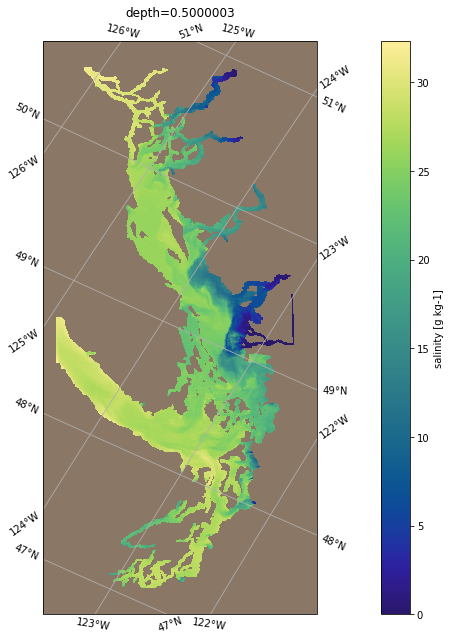

In [29]:
# Use `subplot_kw` arg to pass a dict of kwargs containing the `RotatedPole` CRS
# and the `facecolor` value to the add_subplot() call(s) that subplots() will make
fig, ax = plt.subplots(
    1, 1, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

# Use the `transform` arg to tell cartopy to transform the model field
# between grid coordinates and lon/lat coordinates when it is plotted
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# Colour bar
cbar = plt.colorbar(quad_mesh, ax=ax)
cbar.set_label(f"{salinity.attrs['long_name']} [{salinity.attrs['units']}]")
# Axes title; ax.gridlines() below labels axes tick in a way that makes
# additional axes labels unnecessary IMHO
ax.set_title(f"depth={salinity.depth.item():0.7f}")

# Don't call set_aspect() because plotting on lon/lat grid implicitly makes the aspect ratio correct

# Show grid lines
# Note that ax.grid() has no effect; ax.gridlines() is from cartopy, not matplotlib
ax.gridlines(draw_labels=True, auto_inline=False)

# cartopy doesn't seem to play nice with tight_layout() unless we call canvas.draw() first
fig.canvas.draw()
fig.tight_layout()

The [`cartopy` documentation](https://scitools.org.uk/cartopy/docs/latest/index.html) provides some basic guidance on how to use the package
and what projections it supports.
I also has a gallery of plots with the code that generated them that can be helpful to
figure out how to do things.
But for some things,
like figuring out how `gridlines()` works,
reading the [code on GitHub](https://github.com/SciTools/cartopy) is the best way to go.